# Sparse Target Dataset Hyperparameters Tunning
The objective of this notebook is to tune the hyperparameters of the model to obtain the best performance on the sparse dataset. 

**Summary of the Article**
- Description of the dataset.
- Hyperparameters tunning:
    - Gradient Boosting Regressor.
    - SVRegressor.
    - Multi-Layer Perceptron.
    - Long-Short Term Memory.
- Training Models.
- Next Steps.

## Description of the Sparse Dataset 
The objective of this master thesis is to forecast the occurance and amplitude of constraints in the electrical grid. Using historical values of active and reactive power it is possible to compute the voltage and current values in the network, thus obtaining the occurance and amplitude of constraints. Since not every timestep containts a constraint, not every time step is woth to be predicted, so it is usefull transform the target features into a sequece of values that better represent the constraints. One way to obtain this target dataset is to set all time steps that do not characterise a constraint to 0, a positive value (with the amplitude of the constraint) otherwise. The following formula states the transformation:
$$
    \begin{align}
        \text{Target} &= \begin{cases}
            0 & \text{if} \; \text{constraint} \; \text{is not violated} \\
            \text{amplitude of constraint} & \text{if} \; \text{constraint} \; \text{is violated} \\
        \end{cases}
    \end{align}
$$

The resulting dataset is a sparse dataset, since constraints are not as common as regular values. Bellow the dataset for maximum voltage constraints is shown.

In [3]:
import sys; sys.path.append('..')
from thesis_package import utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns='timestamps')
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test = utils.split_and_suffle(exogenous_data, y_max_u)
data = {'X_train': X_max_u_train, 'X_test': X_max_u_test, 'y_train': y_max_u_train, 'y_test': y_max_u_test}
threshold_value = y_max_u_train.loc[:, y_max_u_train.max(axis=0) != 0].max(axis=0).mean() * 0.1 
threshold_signal = pd.Series(np.ones([len(y_max_u_test)]) * threshold_value)
# Plot prediction_gb_max_u
sns.set(style='whitegrid')
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.plot(y_max_u_test.reset_index(drop=True))
axs.plot(threshold_signal)
axs.set_title('Dataset Sample of Maximum Voltage Constraint', fontsize=30, fontweight='bold')
axs.set_xlabel('Timestep', fontsize=18, fontweight='bold')
axs.set_ylabel('Constraint Value', fontsize=18, fontweight='bold')
plt.show()

AttributeError: module 'scipy' has no attribute '_lib'

The sparse boolean dataset is derived from the one above. It represents the time steps with constraints as of the class 1 and the rest as class 0. This datset is used to train the classification models.

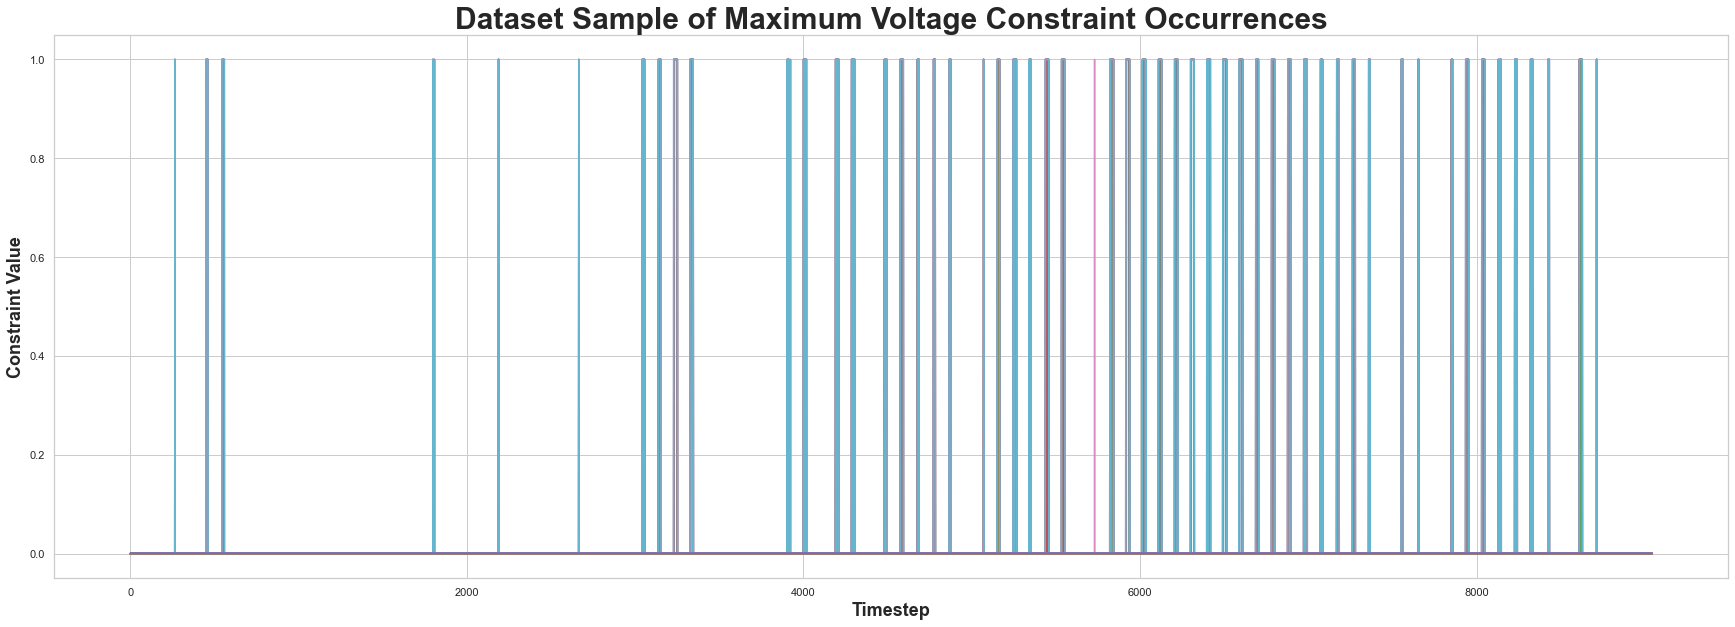

In [ ]:
y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns='timestamps')
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
X_max_u_sparse_bool_train, X_max_u_sparse_bool_test, y_max_u_sparse_bool_train, y_max_u_sparse_bool_test = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool)
data = {'X_train': X_max_u_sparse_bool_train,
        'X_test': X_max_u_sparse_bool_test,
        'y_train': utils.convert_df_to_bool(y_max_u_sparse_bool_train),
        'y_test': utils.convert_df_to_bool(y_max_u_sparse_bool_test)}
# Plot prediction_gb_max_u
sns.set(style='whitegrid')
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.plot(y_max_u_sparse_bool_test.reset_index(drop=True))
axs.plot(threshold_signal)
axs.set_title('Dataset Sample of Maximum Voltage Constraint Occurrences', fontsize=30, fontweight='bold')
axs.set_xlabel('Timestep', fontsize=18, fontweight='bold')
axs.set_ylabel('Constraint Value', fontsize=18, fontweight='bold')
plt.show()

However, not all busses have constraints, so it is only possible train classification models for those busses that have positive values in the target dataset.

In [ ]:
utils.cols_with_positive_values(y_max_u_sparse_bool)

['bus_8',
 'bus_9',
 'bus_10',
 'bus_11',
 'bus_12',
 'bus_13',
 'bus_14',
 'bus_15',
 'bus_16',
 'bus_18']

## Import Libraries

In [ ]:
import optuna 
import os

import numpy as np
import pandas as pd 
import sklearn.metrics
from sklearn.model_selection import train_test_split

import sys
sys.path.append('..')
from thesis_package import aimodels as my_ai, utils, metrics

c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters Tunning of Models
The objective of this section is to tune the hyperparameters of the models to obtain the best performance on the sparse dataset. In order to perfom the hyperparameters tunning, we are going to use the optuna library presented in the `optuna_introduction.ipynb` notebook. The models are the ones implemented in the `aimodel.py` file in the `thesis_package`.

In [ ]:
# General parameters
num_trials = 15

In [ ]:
# Regression
y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
train_x, valid_x, train_y, valid_y, scaler_max = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
data_max_reg = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler_min = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
data_min_reg = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
# Threshold
threshold_max = utils.compute_threshold(y_max_u) / scaler_max['y']
threshold_min = utils.compute_threshold(y_min_u) / scaler_min['y']
print(threshold_min)
print(threshold_max)
# Classification
y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool[utils.cols_with_positive_values(y_max_u_sparse_bool)], test_size=0.2, scaling=True)
data_max_class = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}

y_min_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse_bool[utils.cols_with_positive_values(y_min_u_sparse_bool)], test_size=0.2, scaling=True)
data_min_class = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}

0.06450243730741544
0.054008631153497785


In [ ]:
# Regression
y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
train_x, valid_x, train_y, valid_y, scaler_max = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
data_max_reg = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler_min = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
data_min_reg = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
# Threshold
threshold_max = utils.compute_threshold(y_max_u) / scaler_max['y']
threshold_min = utils.compute_threshold(y_min_u) / scaler_min['y']
print(threshold_min)
print(threshold_max)
# Classification
y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool[utils.cols_with_positive_values(y_max_u_sparse_bool)], test_size=0.2, scaling=True)
data_max_class = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}

y_min_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse_bool[utils.cols_with_positive_values(y_min_u_sparse_bool)], test_size=0.2, scaling=True)
data_min_class = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}

0.06450243730741544
0.054008631153497785


### Extreme Gradient Boosting Regressor

In [8]:
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_max)
    return metric.hybrid_mcc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_regression_sparse_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-11 21:22:47,663] A new study created in memory with name: no-name-2a52eabb-c0ab-4ec4-8434-4bdf0d05f1bb
[I 2022-10-11 21:24:24,186] Trial 0 finished with value: 0.0 and parameters: {'booster': 'gblinear', 'lambda': 0.13670113255180008, 'alpha': 0.5453177075081312, 'subsample': 0.2774171048028863, 'colsample_bytree': 0.49798535922125303}. Best is trial 0 with value: 0.0.
[I 2022-10-11 21:28:35,330] Trial 1 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 6.434183235199802e-07, 'alpha': 2.0240015920198777e-07, 'subsample': 0.8478319879248852, 'colsample_bytree': 0.4545206369114196, 'max_depth': 3, 'min_child_weight': 4, 'eta': 2.9351338886594904e-05, 'gamma': 3.368884300956653e-08, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.0.
[I 2022-10-11 21:31:25,599] Trial 2 finished with value: 0.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0054469246383618535, 'alpha': 0.7277519454819869, 'subsample': 0.26460625093086637, 'colsample_bytree'

Number of finished trials:  30
Best trial:
  Value: 0.48885217429521804
  Params: 
    booster: dart
    lambda: 1.660626170904603e-05
    alpha: 0.17308249083479166
    subsample: 0.4122865849645826
    colsample_bytree: 0.7497490544496421
    max_depth: 9
    min_child_weight: 5
    eta: 0.19322318334438532
    gamma: 2.0254178495480695e-08
    grow_policy: lossguide
    sample_type: weighted
    normalize_type: tree
    rate_drop: 1.7726710493153832e-05
    skip_drop: 1.2261892812507639e-06


In [9]:
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_min)
    return metric.hybrid_mcc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_regression_sparse_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-11 23:36:30,194] A new study created in memory with name: no-name-a543b3eb-7746-419b-a3f7-f43b0d3fd766
[I 2022-10-11 23:37:35,565] Trial 0 finished with value: 0.0 and parameters: {'booster': 'gblinear', 'lambda': 0.6759834895874343, 'alpha': 2.8167088278698263e-08, 'subsample': 0.6769441807817325, 'colsample_bytree': 0.7025913460945041}. Best is trial 0 with value: 0.0.
[I 2022-10-11 23:39:06,001] Trial 1 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 6.013164496331703e-05, 'alpha': 0.007902571123566808, 'subsample': 0.8053802307888185, 'colsample_bytree': 0.2562132164684144, 'max_depth': 3, 'min_child_weight': 5, 'eta': 1.4633632762942516e-06, 'gamma': 2.250856113282099e-08, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.0.
[I 2022-10-11 23:40:38,397] Trial 2 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 5.733747992335217e-05, 'alpha': 0.0001415348931723752, 'subsample': 0.3749952766641846, 'colsample_bytree'

Number of finished trials:  30
Best trial:
  Value: 0.5715224657616713
  Params: 
    booster: gbtree
    lambda: 2.6580291627497087e-05
    alpha: 0.00035117433161679327
    subsample: 0.6864536953686452
    colsample_bytree: 0.5974147772320402
    max_depth: 3
    min_child_weight: 10
    eta: 0.17352920427247187
    gamma: 0.003769732785934237
    grow_policy: lossguide


In [10]:
# Filtered dataset
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u[utils.cols_with_positive_values(y_max_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_max)
    return metric.hybrid_mcc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_regression_filtered_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))


[I 2022-10-12 01:26:31,869] A new study created in memory with name: no-name-7dc14b7a-2cdb-480c-885c-71b16de62098
[I 2022-10-12 01:29:42,490] Trial 0 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 0.00017964929792141853, 'alpha': 0.0031648351078432616, 'subsample': 0.9922238477483589, 'colsample_bytree': 0.9982216755867606, 'max_depth': 5, 'min_child_weight': 10, 'eta': 8.045469349544027e-06, 'gamma': 1.1369260088691975e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.07281184535791267, 'skip_drop': 0.01201102293824107}. Best is trial 0 with value: 0.0.
[I 2022-10-12 01:30:06,154] Trial 1 finished with value: 0.0 and parameters: {'booster': 'gblinear', 'lambda': 1.747370093688566e-08, 'alpha': 0.24763129602696315, 'subsample': 0.8047080395237836, 'colsample_bytree': 0.22418456830145833}. Best is trial 0 with value: 0.0.
[I 2022-10-12 01:31:15,142] Trial 2 finished with value: 0.0 and parameters: {'booster': 'g

Number of finished trials:  30
Best trial:
  Value: 0.37781070621818075
  Params: 
    booster: gblinear
    lambda: 0.11866430098752791
    alpha: 7.678107916591738e-08
    subsample: 0.68972185719216
    colsample_bytree: 0.7875582283226814


In [11]:
# FILTERED DATASET
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u[utils.cols_with_positive_values(y_min_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_min)
    return metric.hybrid_mcc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_regression_filtered_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-12 01:56:12,039] A new study created in memory with name: no-name-918ea2be-dc23-4399-89c6-fbbb65954b0e
[I 2022-10-12 01:57:05,329] Trial 0 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 0.13003119089952495, 'alpha': 0.00012180234152179062, 'subsample': 0.4803928298401274, 'colsample_bytree': 0.5640353488154003, 'max_depth': 7, 'min_child_weight': 10, 'eta': 1.1909090593899545e-07, 'gamma': 0.02102995036875599, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.0.
[I 2022-10-12 01:57:41,242] Trial 1 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 0.006867768124413219, 'alpha': 0.06802782990327548, 'subsample': 0.5473302496546077, 'colsample_bytree': 0.5033349968198105, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.0014426047819873337, 'gamma': 4.3175875977814396e-08, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.0.
[I 2022-10-12 01:58:23,527] Trial 2 finished with value: 0.0 and parameters: {'booster': 

Number of finished trials:  30
Best trial:
  Value: 0.5693427502449294
  Params: 
    booster: dart
    lambda: 0.005458178901423617
    alpha: 1.6298642466112607e-05
    subsample: 0.50984523082815
    colsample_bytree: 0.8403762589775882
    max_depth: 5
    min_child_weight: 5
    eta: 0.10008488866912961
    gamma: 0.08234411404596774
    grow_policy: depthwise
    sample_type: uniform
    normalize_type: tree
    rate_drop: 3.4743978423745048e-06
    skip_drop: 0.9115118249667867


### Gradient Boosting Regressor

In [12]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_regression_sparse_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-12 02:57:41,657] A new study created in memory with name: no-name-15793cbf-27bf-4ab2-812c-ff6da50973d4
[I 2022-10-12 03:01:02,552] Trial 0 finished with value: 0.4436261349663361 and parameters: {'n_estimators': 68, 'learning_rate': 0.7324976560528268, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.4436261349663361.
[I 2022-10-12 03:22:50,594] Trial 1 finished with value: 0.2929447559263532 and parameters: {'n_estimators': 554, 'learning_rate': 0.8268173671691834, 'loss': 'squared_error'}. Best is trial 0 with value: 0.4436261349663361.
[I 2022-10-12 03:52:39,049] Trial 2 finished with value: 0.4922003079283852 and parameters: {'n_estimators': 776, 'learning_rate': 0.4959842937898038, 'loss': 'absolute_error'}. Best is trial 2 with value: 0.4922003079283852.
[I 2022-10-12 04:26:36,476] Trial 3 finished with value: 0.2741372296059747 and parameters: {'n_estimators': 838, 'learning_rate': 0.541835087979734, 'loss': 'squared_error'}. Best is trial 2 with value: 0.4922

Number of finished trials:  30
Best trial:
  Value: 0.5832949193199729
  Params: 
    n_estimators: 35
    learning_rate: 0.10151303474774298
    loss: squared_error


In [13]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_regression_sparse_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-12 06:31:56,336] A new study created in memory with name: no-name-0de84fcd-729c-4095-ab17-923a4fa1fa4c
[I 2022-10-12 06:37:43,508] Trial 0 finished with value: 0.5011759326079707 and parameters: {'n_estimators': 135, 'learning_rate': 0.4753077586826183, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.5011759326079707.
[I 2022-10-12 06:39:33,552] Trial 1 finished with value: 0.4967104412408474 and parameters: {'n_estimators': 29, 'learning_rate': 0.1536040432198943, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.5011759326079707.
[I 2022-10-12 06:48:23,594] Trial 2 finished with value: 0.530351602545954 and parameters: {'n_estimators': 292, 'learning_rate': 0.42999779581535297, 'loss': 'squared_error'}. Best is trial 2 with value: 0.530351602545954.
[I 2022-10-12 06:50:30,660] Trial 3 finished with value: 0.49515805695015075 and parameters: {'n_estimators': 55, 'learning_rate': 0.8854087148777033, 'loss': 'absolute_error'}. Best is trial 2 with value: 0.530

Number of finished trials:  30
Best trial:
  Value: 0.5770484591592312
  Params: 
    n_estimators: 45
    learning_rate: 0.10053825502708152
    loss: squared_error


In [14]:
# FILTERED DATA
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u[utils.cols_with_positive_values(y_max_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_regression_filtered_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-12 08:21:14,852] A new study created in memory with name: no-name-476b1b42-b579-4075-bf2e-7ca7a2dc756b
[I 2022-10-12 08:32:13,608] Trial 0 finished with value: 0.4372020519488369 and parameters: {'n_estimators': 492, 'learning_rate': 0.7692160543645895, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.4372020519488369.
[I 2022-10-12 08:41:29,789] Trial 1 finished with value: 0.24859420447800437 and parameters: {'n_estimators': 332, 'learning_rate': 0.2124691816434439, 'loss': 'squared_error'}. Best is trial 0 with value: 0.4372020519488369.
[I 2022-10-12 08:44:00,306] Trial 2 finished with value: 0.4465581606115185 and parameters: {'n_estimators': 92, 'learning_rate': 0.37775206744331363, 'loss': 'absolute_error'}. Best is trial 2 with value: 0.4465581606115185.
[I 2022-10-12 08:46:58,772] Trial 3 finished with value: 0.25670397345101914 and parameters: {'n_estimators': 103, 'learning_rate': 0.4086253587422581, 'loss': 'squared_error'}. Best is trial 2 with value: 0.

Number of finished trials:  30
Best trial:
  Value: 0.4943841615568088
  Params: 
    n_estimators: 896
    learning_rate: 0.5030561636951839
    loss: absolute_error


In [15]:
# FILTERED DATA
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u[utils.cols_with_positive_values(y_min_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_regression_filtered_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-12 13:56:48,670] A new study created in memory with name: no-name-b66e76e4-2708-4477-a025-6b52ca748825
[I 2022-10-12 13:57:13,974] Trial 0 finished with value: 0.5451986637661478 and parameters: {'n_estimators': 13, 'learning_rate': 0.21973739213760063, 'loss': 'squared_error'}. Best is trial 0 with value: 0.5451986637661478.
[I 2022-10-12 13:57:55,003] Trial 1 finished with value: 0.4324163991846127 and parameters: {'n_estimators': 25, 'learning_rate': 0.2695519266391299, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.5451986637661478.
[I 2022-10-12 13:58:43,689] Trial 2 finished with value: 0.4335527183022466 and parameters: {'n_estimators': 31, 'learning_rate': 0.34905028895291246, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.5451986637661478.
[I 2022-10-12 14:10:35,038] Trial 3 finished with value: 0.5190477803355567 and parameters: {'n_estimators': 544, 'learning_rate': 0.31645450039025347, 'loss': 'squared_error'}. Best is trial 0 with value: 0.54

Number of finished trials:  30
Best trial:
  Value: 0.5655126692733458
  Params: 
    n_estimators: 120
    learning_rate: 0.21976816397532475
    loss: squared_error


### Gradient Boosting Classifier

In [16]:
# Implement as above but for multi-output classification grandient boost classifier.
def objective(trial):
    # import data0 
    y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
    # y_max_u_sparse_bool = utils.convert_df_to_bool(y_max_u_sparse_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool[utils.cols_with_positive_values(y_max_u_sparse_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['log_loss', 'deviance', 'exponential']) 
    }
    model = my_ai.Context(my_ai.GradientBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_max_u_sparse_bool))
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (valid_y[bus] == 1))
        tn += sum((prediction[bus] == 0) & (valid_y[bus] == 0))
        fp += sum((prediction[bus] == 1) & (valid_y[bus] == 0))
        fn += sum((prediction[bus] == 0) & (valid_y[bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_sparse_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-12 16:43:49,736] A new study created in memory with name: no-name-41f46623-fb85-4f1b-91e1-6baf0fe9726a
[I 2022-10-12 17:00:27,027] Trial 0 finished with value: 0.1848224343384773 and parameters: {'n_estimators': 700, 'learning_rate': 0.9467454850439413, 'loss': 'log_loss'}. Best is trial 0 with value: 0.1848224343384773.
[I 2022-10-12 17:01:46,969] Trial 1 finished with value: 0.4564203796934115 and parameters: {'n_estimators': 52, 'learning_rate': 0.15488788414815047, 'loss': 'exponential'}. Best is trial 1 with value: 0.4564203796934115.
[I 2022-10-12 17:02:14,227] Trial 2 finished with value: 0.3189708387625145 and parameters: {'n_estimators': 18, 'learning_rate': 0.12158016444499965, 'loss': 'exponential'}. Best is trial 1 with value: 0.4564203796934115.
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in 

Number of finished trials:  30
Best trial:
  Value: 0.4930738124699334
  Params: 
    n_estimators: 913
    learning_rate: 0.4468180639904589
    loss: exponential


In [17]:
# Implement as above but for multi-output classification grandient boost classifier.
def objective(trial):
    # import data0 
    y_min_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
    # y_min_u_sparse_bool = utils.convert_df_to_bool(y_min_u_sparse_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse_bool[utils.cols_with_positive_values(y_min_u_sparse_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['log_loss', 'deviance', 'exponential']) 
    }
    model = my_ai.Context(my_ai.GradientBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_min_u_sparse_bool))
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (valid_y[bus] == 1))
        tn += sum((prediction[bus] == 0) & (valid_y[bus] == 0))
        fp += sum((prediction[bus] == 1) & (valid_y[bus] == 0))
        fn += sum((prediction[bus] == 0) & (valid_y[bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_sparse_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-12 21:11:46,224] A new study created in memory with name: no-name-93f1c8d1-b896-47bb-a141-297d8e2b78fc
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprec

Number of finished trials:  30
Best trial:
  Value: 0.5919063880540413
  Params: 
    n_estimators: 12
    learning_rate: 0.31841154564479685
    loss: deviance


### Support Vector Regressor

In [18]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=y_max_u.columns)
    train_y = pd.DataFrame(train_y, columns=y_max_u.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_regression_sparse_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-12 22:19:13,790] A new study created in memory with name: no-name-2b44118b-9d6a-4f81-8e86-eafe6cede960
[I 2022-10-12 22:29:03,587] Trial 0 finished with value: 0.17935944056633119 and parameters: {'kernel': 'poly', 'C': 6.559448577815634e-05, 'degree': 4, 'gamma': 0.00013943996378102115}. Best is trial 0 with value: 0.17935944056633119.
[I 2022-10-12 22:36:30,148] Trial 1 finished with value: 0.17934301269870043 and parameters: {'kernel': 'rbf', 'C': 0.03736561630204268, 'degree': 1, 'gamma': 1.3937317777251808e-07}. Best is trial 0 with value: 0.17935944056633119.
[I 2022-10-12 22:45:02,732] Trial 2 finished with value: 0.17935514379230397 and parameters: {'kernel': 'rbf', 'C': 0.0021209065232645034, 'degree': 4, 'gamma': 7.682328756615118e-07}. Best is trial 0 with value: 0.17935944056633119.
[I 2022-10-12 22:56:54,285] Trial 3 finished with value: 0.17935473210159725 and parameters: {'kernel': 'rbf', 'C': 6.747379407198382e-06, 'degree': 2, 'gamma': 6.071233165025852e-07}

In [ ]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=y_min_u.columns)
    train_y = pd.DataFrame(train_y, columns=y_min_u.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_regression_sparse_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

In [ ]:
# FILTERED DATA
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u[utils.cols_with_positive_values(y_max_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=utils.cols_with_positive_values(y_max_u))
    valid_y = pd.DataFrame(valid_y, columns=utils.cols_with_positive_values(y_max_u))
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_regression_filtered_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

In [ ]:
# DATA FILTERED
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u[utils.cols_with_positive_values(y_min_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=utils.cols_with_positive_values(y_min_u))
    train_y = pd.DataFrame(train_y, columns=utils.cols_with_positive_values(y_min_u))
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_regression_filtered_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

### Extreme Gradient Boosting Classifier

In [ ]:
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
    #y_max_u = utils.convert_df_to_bool(y_max_u)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u[utils.cols_with_positive_values(y_max_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (valid_y[bus] == 1))
        tn += sum((prediction[bus] == 0) & (valid_y[bus] == 0))
        fp += sum((prediction[bus] == 1) & (valid_y[bus] == 0))
        fn += sum((prediction[bus] == 0) & (valid_y[bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_sparse_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))


In [ ]:
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
    #y_min_u = utils.convert_df_to_bool(y_min_u)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u[utils.cols_with_positive_values(y_min_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (valid_y[bus] == 1))
        tn += sum((prediction[bus] == 0) & (valid_y[bus] == 0))
        fp += sum((prediction[bus] == 1) & (valid_y[bus] == 0))
        fn += sum((prediction[bus] == 0) & (valid_y[bus] == 1))
    if (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) > 0:
        mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    else: 
        mcc_score = 0
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_sparse_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

### Support Vector Classifier

In [ ]:
# Same implementation as above, but for Support Vector Classifier.
def objective(trial):
    # import data
    y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
    # y_max_u_sparse_bool = utils.convert_df_to_bool(y_max_u_sparse_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool[utils.cols_with_positive_values(y_max_u_sparse_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction, columns=valid_y.columns)
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (valid_y[bus] == 1))
        tn += sum((prediction[bus] == 0) & (valid_y[bus] == 0))
        fp += sum((prediction[bus] == 1) & (valid_y[bus] == 0))
        fn += sum((prediction[bus] == 0) & (valid_y[bus] == 1))
    if (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) > 0:
        mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    else:
        mcc_score = 0
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_sparse_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

In [ ]:
# Same implementation as above, but for Support Vector Classifier.
def objective(trial):
    # import data
    y_min_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
    # y_min_u_sparse_bool = utils.convert_df_to_bool(y_min_u_sparse_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse_bool[utils.cols_with_positive_values(y_min_u_sparse_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction, columns=valid_y.columns)
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (valid_y[bus] == 1))
        tn += sum((prediction[bus] == 0) & (valid_y[bus] == 0))
        fp += sum((prediction[bus] == 1) & (valid_y[bus] == 0))
        fn += sum((prediction[bus] == 0) & (valid_y[bus] == 1))
    if (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) > 0:
        mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    else:
        mcc_score = 0
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_sparse_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

In [ ]:
import beepy
beepy.beep(6)

In [ ]:
pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv')